In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import warnings

# 모든 FutureWarning 무시
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Processing

In [2]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images, images_test = list(), list()
    spots, spots_test = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = np.array(train_images[slide_name])
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
            """if slide_name == 'S_1':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 50,
                    y = lambda x: x['y'] - 50,
                )
            el"""
            if slide_name == 'S_2':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 60,
                    y = lambda x: x['y'] - 60,
                )
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = np.array(test_images[sample])
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images_test.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots_test.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = 0))
    # EfficientNet의 형식으로 바꿉니다.
    with tf.device('/CPU:0'):
        images = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images))
    df_spots = pd.concat(spots).reset_index(drop = True)
    with tf.device('/CPU:0'):
        images_test = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images_test))
    df_spots_test = pd.concat(spots_test).reset_index(drop = True)
    return images, df_spots, images_test, df_spots_test

def make_img_proc_info(df, img_with, img_height):
    """
    
    """
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )

def create_tf_ds(df):
    if (pd.Series(targets).isin(df.columns)).all():
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[targets2])
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X, images):
    return tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    )

augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

images, df_spots, images_test, df_spots_test = load_data("data/elucidata_ai_challenge_data.h5")
targets = [i for i in df_spots.columns if i.startswith('C')]
n_components = 5
target_proc = make_pipeline(
    FunctionTransformer(np.log, np.exp), StandardScaler(), PCA(n_components=n_components)
).fit(df_spots[targets])
target_proc.fit(df_spots[targets])
targets2 = ['pca_{}'.format(i) for i in range(n_components)]
df_spots= df_spots.join(
    pd.DataFrame(target_proc.transform(df_spots[targets]), index = df_spots.index, columns = targets2)
)

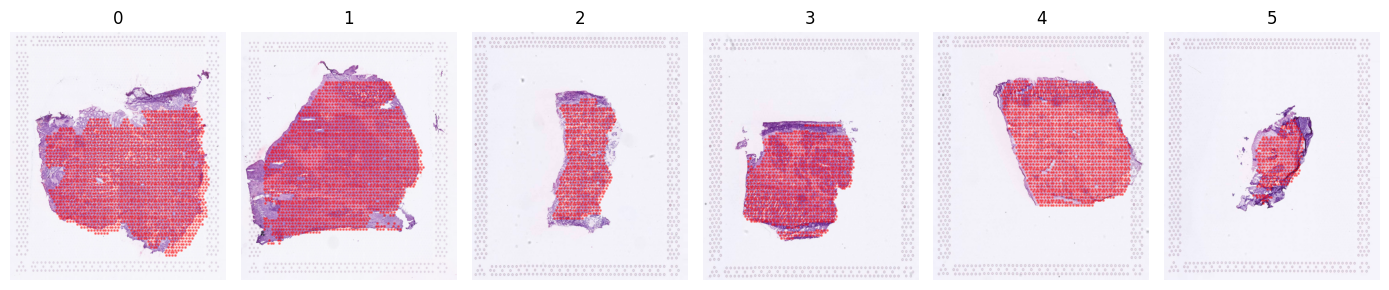

In [3]:
fig, ax = plt.subplots(1, 6, figsize=(14, 3))
for i, slide_name in enumerate(range(6)):
    image = images[i]
    x, y = df_spots.loc[df_spots['slide'] == i, "x"], df_spots.loc[df_spots['slide'] == i, "y"]

    ax[i].imshow(image, aspect="auto")
    ax[i].scatter(x, y, color="red", s=1, alpha=0.4)  # Overlay spot locations
    ax[i].set_title(slide_name)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
df_spots['slide'].unique()

array([0, 1, 2, 3, 4, 5])

In [5]:
from scipy.stats import spearmanr

def create_model(img_width, img_height):
    input_shape = (img_width, img_height, 3)
    enet = tf.keras.applications.EfficientNetB1(
        include_top = False, 
        weights = 'imagenet',
        input_shape = input_shape,
        pooling = 'avg'
    )
    inputs = tf.keras.Input(shape = input_shape)
    x = enet(inputs, training = False)
    x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(256, activation = 'relu', kernel_initializer = 'HeUniform')
    x = d1(x)
    d2 = tf.keras.layers.Dense(len(targets2))
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

def reconstruct_model(layers):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    x = layers[0](inputs, training = True)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = layers[1](x)
    outputs = layers[2](x)
    m = tf.keras.models.Model(inputs, outputs)
    return m

def train_model(
        m, train_idx, valid_idx, learning_rate, 
        target_proc = FunctionTransformer(lambda x: x, lambda x: x), 
        batch_size = 32, epochs = 20, step = ''
    ):

    ds_cv_train = create_tf_ds(
        df_spots.iloc[train_idx].pipe(
            lambda x: pd.concat([
                x, x.sample(n = batch_size - (len(x) % batch_size))
            ])
        )
    ).shuffle(5000).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).map(
        lambda X, Y: (data_augmentation(X), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

    ds_cv_prd = create_tf_ds(
        df_spots.iloc[train_idx]
    ).map(
        lambda X, Y: (proc_images(X, images), Y)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    
    if valid_idx is not None:
        ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
            lambda X, Y: (proc_images(X, images), Y)
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    else:
        ds_valid = None
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=3000,
        alpha=0.1
    )
#    lr_schedule = learning_rate
    m.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        metrics = [tf.keras.metrics.MeanSquaredError()]
    )

    df_true_train = df_spots.iloc[train_idx][targets]
    if valid_idx is not None:
        df_true = df_spots.iloc[valid_idx][targets]
    else:
        df_true = None
    progress_bar = tqdm(total = epochs, desc=step)
    scores_train, scores_valid = list(), list()
    df_prd = None
    for i in range(epochs):
        hist = m.fit(ds_cv_train, epochs = 1, verbose = 0)
        df_prd = pd.DataFrame(
            target_proc.inverse_transform(m.predict(ds_cv_prd, verbose = 0)), 
            index = df_true_train.index, columns = targets
        )
        scores_train.append(
            df_true_train.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
        )
        metric = "train coef: {:.4f}".format(scores_train[-1])
        if valid_idx is not None:
            df_prd = pd.DataFrame(
                target_proc.inverse_transform(m.predict(ds_valid, verbose = 0)), 
                index = df_true.index, columns = targets
            )
            scores_valid.append(
                df_true.apply(lambda x: spearmanr(x, df_prd.loc[x.name])[0], axis=1).mean()
            )
            metric = metric + ", valid coef: {:.4f}".format(scores_valid[-1])
        progress_bar.set_postfix_str(metric)
        progress_bar.update(1)
    progress_bar.close()
    return (scores_train, scores_valid), df_prd

# Validation

In [6]:
img_width = 224
img_height = 224
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [7]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 6)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    gkf.split(df_spots[['x', 'y']], df_spots[targets], groups = df_spots['slide'])
):
    m, layers = create_model(img_width, img_height)
    score_1, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-7, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'train {}'.format(i)
    )
    """
    m = reconstruct_model(layers)
    score_2, df_prd = train_model(
        m, train_idx, valid_idx, learning_rate = 1e-6, 
        target_proc = target_proc, batch_size = 32, epochs = 10, step = 'fine tuning {}'.format(i)
    )
    """
    scores.append(score_1)
    oofs.append(df_prd)
df_oof = pd.concat(oofs, axis = 0)

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


train 0:   0%|          | 0/10 [00:00<?, ?it/s]

train 1:   0%|          | 0/10 [00:00<?, ?it/s]

train 2:   0%|          | 0/10 [00:00<?, ?it/s]

train 3:   0%|          | 0/10 [00:00<?, ?it/s]

train 4:   0%|          | 0/10 [00:00<?, ?it/s]

train 5:   0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
from scipy.stats import spearmanr
df_oof[targets].groupby(df_spots['slide']).apply(
    lambda x: x.apply(lambda x: spearmanr(df_spots.loc[x.name, targets], x)[0], axis = 1).mean()
)

slide
0    0.494688
1    0.716031
2    0.653993
3    0.465905
4    0.385892
5    0.543335
dtype: float64

In [9]:
from scipy.stats import spearmanr
df_oof[targets].apply(
    lambda x: spearmanr(df_spots.loc[x.name, targets], x)[0], axis=1
).mean()

0.5440003046373658

In [10]:
joblib.dump((df_oof, scores), 'result/cv_log_std_pca_5_eff_b1_S2_mse.joblib')

['result/cv_log_std_pca_5_eff_b1_S2_mse.joblib']

# Train

In [11]:
img_width = 224
img_height = 224
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [12]:
m, layers = create_model(img_width, img_height)
score_1, df_prd = train_model(
    m, df_spots.index, None, learning_rate = 1e-7, 
    target_proc = target_proc, batch_size = 32, epochs = 10, step = 'train'
)

train:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
"""
inputs = tf.keras.Input(shape = input_shape)
x = enet(inputs, training = True)
x = tf.keras.layers.Dropout(0.2)(x)
x = d1(x)
outputs = d2(x)
m = tf.keras.models.Model(inputs, outputs)
m.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # Low learning rate
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)
hist = m.fit(ds_train, epochs=10)
"""
''

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - loss: 0.8789 - mean_squared_error: 0.8789
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - loss: 0.8748 - mean_squared_error: 0.8748
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - loss: 0.8705 - mean_squared_error: 0.8705
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.8666 - mean_squared_error: 0.8666
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 0.8645 - mean_squared_error: 0.8645
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - loss: 0.8619 - mean_squared_error: 0.8619
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.8578 - mean_squared_error: 0.8578
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.8542 - mean_squared_error: 0.8542
Epoch 9/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.8518 - mean_squared_error: 0.8518
Epoch 10/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 0.8491 - mean_squared_error: 0.8491


In [15]:
joblib.dump(m.get_weights(), 'model/log_std_pca_5_eff_b1_S2_mse.joblib')

['model/log_std_pca_5_eff_b1_S2_mse.joblib']

In [16]:
joblib.dump(target_proc, 'model/target_proc_log_std_pca_5_eff_b1_S2_mse.joblib') 

['model/target_proc_log_std_pca_5_eff_b1_S2_mse.joblib']